In [1]:
import wrangle

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from env import user, password, host
import env
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import csv
import modeling
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
zillow_train,zillow_validate,zillow_test=wrangle.wrangled_file()

In [3]:
zillow_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42993 entries, 0 to 42992
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bathroom                    42993 non-null  object 
 1   bedroom                     42993 non-null  object 
 2   calculatedbathnbr           42993 non-null  object 
 3   sqtft                       42993 non-null  object 
 4   finishedsquarefeet12        42993 non-null  object 
 5   fips                        42993 non-null  object 
 6   fullbathcnt                 42993 non-null  object 
 7   latitude                    42993 non-null  object 
 8   longitude                   42993 non-null  object 
 9   lots                        42993 non-null  object 
 10  propertycountylandusecode   42993 non-null  object 
 11  propertyzoningdesc          42993 non-null  object 
 12  rawcensustractandblock      42993 non-null  object 
 13  zipcode                     429

In [4]:
zillow_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,42993.0,53.480613,23.85362,6.0,35.0,52.0,69.0,156.0


In [10]:
def scale(scaler,zillow_train,cols=['bedroom','bathroom','sqtft','lots','fullbathcnt',],return_scaler=True):
    zillow_train=zillow_train
    zillow_train_scaled=zillow_train.copy()
    scaler=scaler
    zillow_train_scaled[cols] = scaler.fit_transform(zillow_train[cols])
    return scaler, zillow_train_scaled

In [11]:
scaler,zillow_scaled=scale(MinMaxScaler(),zillow_train)

In [12]:
zillow_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42993 entries, 0 to 42992
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bathroom                    42993 non-null  float64
 1   bedroom                     42993 non-null  float64
 2   calculatedbathnbr           42993 non-null  object 
 3   sqtft                       42993 non-null  float64
 4   finishedsquarefeet12        42993 non-null  object 
 5   fips                        42993 non-null  object 
 6   fullbathcnt                 42993 non-null  float64
 7   latitude                    42993 non-null  object 
 8   longitude                   42993 non-null  object 
 9   lots                        42993 non-null  float64
 10  propertycountylandusecode   42993 non-null  object 
 11  propertyzoningdesc          28254 non-null  object 
 12  rawcensustractandblock      42993 non-null  object 
 13  zipcode                     429

In [13]:
zillow_scaled.describe()

,bathroom,bedroom,sqtft,fullbathcnt,lots,age
count,42993.000000,42993.000000,42993.000000,42993.000000,42993.000000,42993.000000
mean,0.128429,0.219464,0.043759,0.073753,0.003921,53.480613
std,0.055215,0.080305,0.027362,0.057063,0.016933,23.853620
min,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,0.111111,0.142857,0.026725,0.058824,0.000820,35.000000
50%,0.111111,0.214286,0.036866,0.058824,0.000949,52.000000
75%,0.166667,0.285714,0.052884,0.117647,0.001487,69.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,156.000000


## Question 1
- Whether there has relationship between LogError and Age

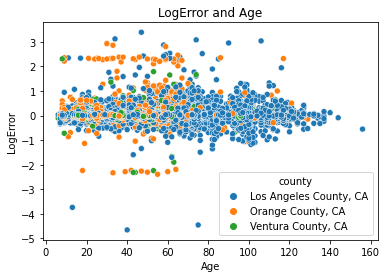

In [9]:
# plot age by logerror
sns.scatterplot(x=zillow_train.age, y=zillow_train.logerror,hue=zillow_train.county)
plt.xlabel("Age")
plt.ylabel("LogError")
plt.title("LogError and Age")
plt.show()

## Key Takeaway
- The age and log error don't seem to have any significant relationship in county when they pass age 80.
- Majority of them within 60 years built has significant log error with orange county
- The next step exploration would be whether there are signicant relationship with the taxrate and logerror

## Question 2
- Whether there has relationship between taxrate and logerror 

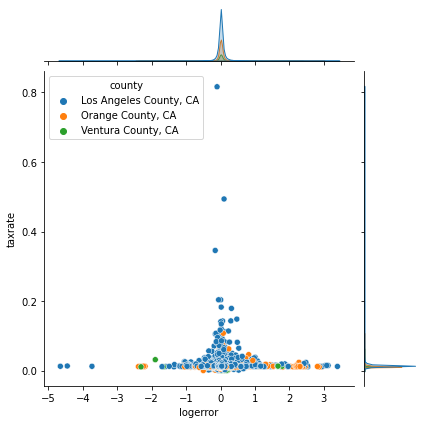

In [10]:
sns.jointplot(y="taxrate", x="logerror", data=zillow_train, hue = 'county')
plt.xlabel("county")
plt.ylabel("Logerror")
plt.show()

## Key Takeaway
- The logerror has showing significant with orange county, which is like what happened to the age
- The next step would be focusing on orange county to explore further for the reason of logerror

In [11]:
alpha = .05

In [12]:
zillow_train.county.value_counts()

Los Angeles County, CA    28367
Orange County, CA         11220
Ventura County, CA         3406
Name: county, dtype: int64

In [13]:
import scipy.stats as stats
orange = zillow_train[zillow_train.county== 'Orange County, CA'].logerror
other = zillow_train[zillow_train.county!='Orange County, CA'].logerror
orange.var(), other.var()

(0.03630442235880422, 0.024348051074824278)

In [14]:
t, p = stats.ttest_ind(orange, other, equal_var=False)
print(t, p/2, alpha)

4.144200395350684 1.713345846461652e-05 0.05


In [15]:
if p/2 > alpha:
    print("We fail to reject H0")
elif t < 0:
    print("We fail to reject H0")
else:
    print("We reject H0 ")

We reject H0 


## Key Takeaway
- The orange county has significant different on the logerror compare to the other counties
- The orange county has 59.9% variable higher than other countiers 

## Question 4
- Is there a significant different between logerror and the bathroom and bedroom counts 

Is there a relationship
between room count and logerror?


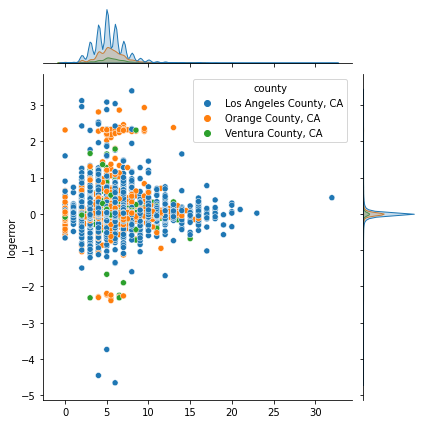

In [16]:
#creating a joinplot to see if any linear relationship
print("Is there a relationship\nbetween room count and logerror?")
room=zillow_train['bathroom']+zillow_train['bedroom']
sns.jointplot(x=room, y='logerror', data=zillow_train, hue = 'county')
plt.xlabel("Room")
plt.ylabel("Logerror")
plt.show()

In [17]:
zillow_train[zillow_train.logerror>=1.5].county.value_counts()

Orange County, CA         41
Los Angeles County, CA    26
Ventura County, CA         4
Name: county, dtype: int64

## Key Takeaway
- The orange county has significant higher logerror
- The orange county has higher logerror with room count between 3-8
- The logerror plays significant role on logerror
- Would recommend doing the prediction seperately with orange county to be one and rest of the county to be the other one

## Question 5
- Can we achieve lower logerror when seperate orange county out of overall 

<AxesSubplot:xlabel='county'>

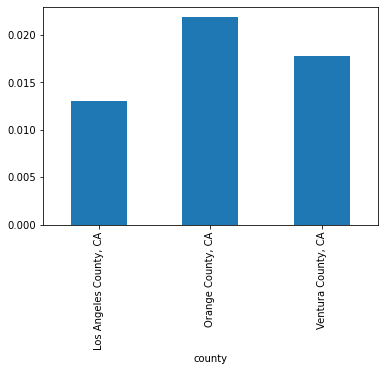

In [18]:
zillow_train.groupby('county').logerror.mean().plot.bar()

In [62]:
zillow_train['county1']=zillow_train['county'].replace(['Los Angeles County, CA', 'Ventura County, CA'], 'Other')

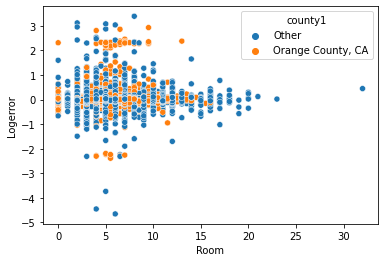

In [63]:
sns.scatterplot(x=nroom, y='logerror', data=zillow_train, hue='county1')
plt.xlabel("Room")
plt.ylabel("Logerror")
plt.show()

In [72]:
zillow_train.logerror.mean()-zillow_train[zillow_train.county1=='Other'].logerror.mean()

0.0021635874052754207

## Key Takeaway
- If we remove the orange county, the logerror doesn't have significant change
- The modeling would not remove the orange county

In [4]:
#use function to scale features and concat them back to dataframe
scaled_train,scaled_validate,scaled_test = modeling.scale_data(zillow_train,zillow_validate,zillow_test,cols=['longitude','latitude'])

In [5]:
scaled_train.head(1)

,bathroom,bedroom,calculatedbathnbr,sqtft,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lots,...,censustractandblock,logerror,heatingorsystemdesc,propertylandusedesc,county,taxrate,month,age,longitude_scaled,latitude_scaled
0,3.0,3.0,3.0,1882.0,1882.0,6037.0,3.0,33890566.0,-118154278.0,15090.0,...,60375539013005.0,0.112968,Central,Condominium,"Los Angeles County, CA",0.013491,5,30.0,0.687813,0.372515


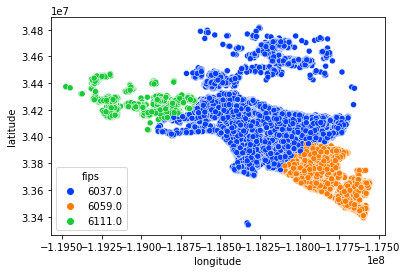

In [24]:
sns.scatterplot(x='longitude', y = 'latitude', data=scaled_train, hue='fips', palette = "bright")
plt.show()

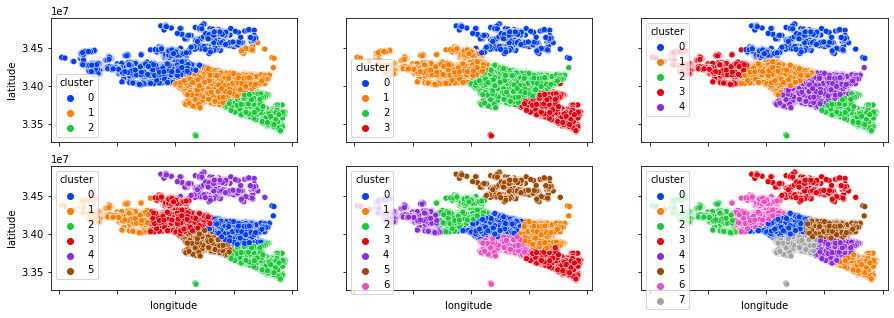

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharey=True, sharex=True)

for i, k in enumerate(range(3,9)):
    
    # creating clusters with KMeans
    x = scaled_train[['latitude_scaled', 'longitude_scaled']]
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    scaled_train['cluster'] = kmeans.predict(x)

    # visualize the clusters
    y = int(i / 3)
    x = i % 3
    ax = sns.scatterplot(data=scaled_train, x='longitude', y='latitude', hue='cluster',
                         palette='bright', ax=axes[y,x])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

Text(0.5, 1.0, 'change in inertia as k increase')

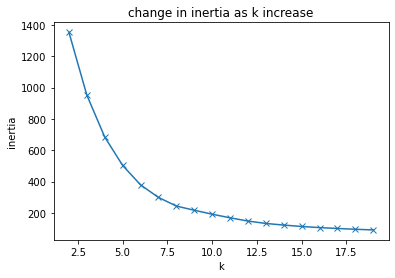

In [21]:
x = scaled_train[['latitude_scaled', 'longitude_scaled']]
pd.Series({k:KMeans(n_clusters= k).fit(x).inertia_ for k in range(2,20)}).plot(marker = "x")
plt.xlabel("k")
plt.ylabel("inertia")
plt.title("change in inertia as k increase")

### Modeling

These are the features to use in our models:
'bedroom','bathroom','age','month','taxrate'

#### Scaling data:
Since our numeric columns are in different scales, for sake of modeling, we will scale them using MinMaxScaler.

In [4]:
#use function to scale features and concat them back to dataframe
scaled_train,scaled_validate,scaled_test = modeling.scale_data(zillow_train,zillow_validate,zillow_test,cols=['bedroom','bathroom','age','month','taxrate'])

In [5]:
#check the scaled features
scaled_train.head(1)

,bathroom,bedroom,calculatedbathnbr,sqtft,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lots,...,propertylandusedesc,county,taxrate,month,age,bedroom_scaled,bathroom_scaled,age_scaled,month_scaled,taxrate_scaled
0,3.0,3.0,3.0,1882.0,1882.0,6037.0,3.0,33890566.0,-118154278.0,15090.0,...,Condominium,"Los Angeles County, CA",0.013491,5,30.0,0.214286,0.166667,0.16,0.5,0.01641


Divide data in X and y sets 

In [6]:
# X: only independent features
#y: target only
features = ['bedroom_scaled', 'bathroom_scaled', 'age_scaled','month_scaled', 'taxrate']
target = ["logerror"]
X_train = scaled_train[features]
y_train = scaled_train[target]
X_validate = scaled_validate[features]
y_validate = scaled_validate[target]
X_test = scaled_test[features]
y_test = scaled_test[target]

In [7]:
#peek at X_train
X_train.head(1)

,bedroom_scaled,bathroom_scaled,age_scaled,month_scaled,taxrate
0,0.214286,0.166667,0.16,0.5,0.013491


In [8]:
#peek at y_train
y_train.head(1)

,logerror
0,0.112968


#### Baseline

Baseline represents the prediction of logerror with out using features. We will use mean and median of our target from train data and calculate lower baseline RMSE. Our models will then aim to beat this baseline RMSE.

In [9]:
#apply baseline value to train and validate
y_train["baseline_mean"] = y_train.logerror.mean()
y_train["baseline_median"] =y_train.logerror.median()
y_validate["baseline_mean"] = y_validate.logerror.mean()
y_validate["baseline_median"] =y_validate.logerror.median()

In [10]:
#call function that calculates the baseline using mean and median
modeling.get_baseline(y_train,y_validate)

RMSE using Mean on 
Train:  0.16577148 
Validate:  0.17664516

RMSE using Median on 
Train:  0.16603937 
Validate:  0.17702764


    since rmse using mean is smaller, we use mean for baseline rmse

How is our target distribution?

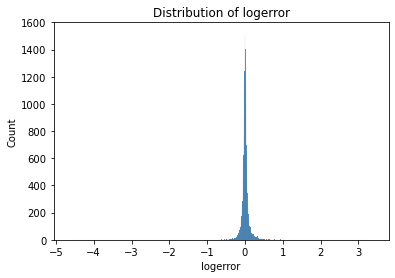

In [11]:
# visualise my target varaible
sns.histplot(y_train.logerror)
plt.title('Distribution of logerror')
plt.show()

    Distribution seems normal

#### Model 1: Linear regression

In [12]:
modeling.linear_regression(X_train,y_train,X_validate,y_validate)

RMSE for OLS using LinearRegression
Training/In-Sample 0.16570285 
Validation/Out-of-Sample:  0.17656305


#### Model 2: LASSOLARS

In [13]:
modeling.lasso_lars(X_train, y_train, X_validate, y_validate, alpha = 1)

RMSE for Lasso + Lars, alpha =  1 
Training/In-Sample:  0.16577148 
Validation/Out-of-Sample:  0.17667237


#### Model 3: Polynomial regression

In [14]:
modeling.polynomial_regression(X_train, y_train, X_validate, y_validate, degree = 2)

RMSE for Polynomial Model, degrees= 2 
Training/In-Sample:  0.1655114 
Validation/Out-of-Sample:  0.17646484


In [15]:
data = {'Model Used':  ['Baseline','Linear regression', 'LassoLars','Polynomial-2'],
        'RMSE: Training': ['0.16577148', '0.16570285','0.16577148','0.16551148'],
        'RMSE: Validate': ['0.17664516','0.17656305','0.17667237','0.17646484']
        }

df = pd.DataFrame(data)

print (df)

          Model Used RMSE: Training RMSE: Validate
0           Baseline     0.16577148     0.17664516
1  Linear regression     0.16570285     0.17656305
2          LassoLars     0.16577148     0.17667237
3       Polynomial-2     0.16551148     0.17646484


    Best model is Polynomial regression, degree 2
    However it is beats baseline by only 0.00027. 
    We will use this model in our unseen sample to predict logerror

Visualise our model performance

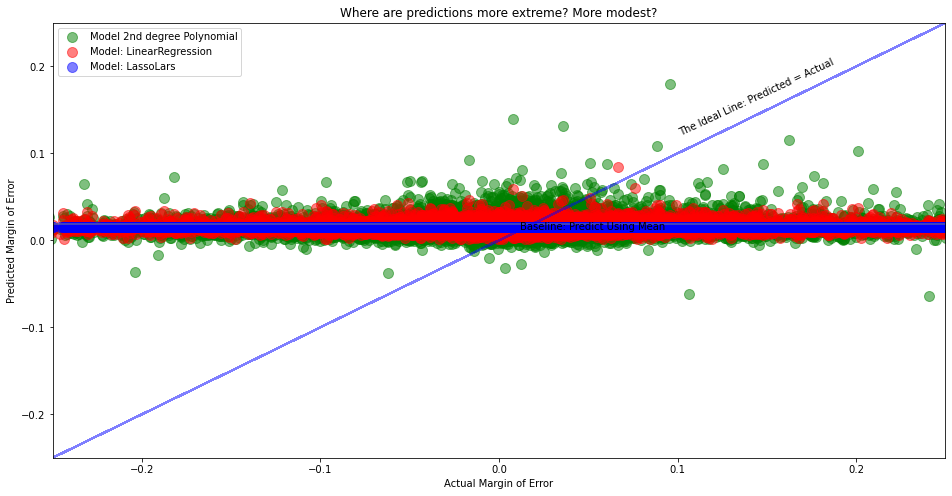

In [16]:
modeling.model_performance(y_validate)

In [12]:
#test predict

modeling.test_prediction(X_train,y_train,X_test,y_test,degree =2)

RMSE for Polynomial Model, degrees= 2 
test:  0.1694646164582976 
r^2:  0.0017127609760738682


    This model is not recommendated to use to predict logerror

In [15]:
#peek the actual vs predicted logerror
y_test.head(2)

,logerror,logerror_pred_lm5
0,-0.018377,0.014401
1,0.012716,0.007287


### Conclusion:
All models performed better than the baseline, even if not by much

### Given more time
I would like to look deeper into other clusters with better features